In [1]:
 !pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [01:18<00:00, 31.6MB/s]
100% 2.29G/2.29G [01:18<00:00, 31.4MB/s]


In [6]:
!unzip -q /content/chest-xray-pneumonia.zip

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2 # import cv2

import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random

In [8]:
train_folder = '/content/chest_xray/train'
test_folder = '/content/chest_xray/test'
val_folder = '/content/chest_xray/val'

In [9]:
labels = ["NORMAL", "PNEUMONIA"] # each folder has two sub folder name "PNEUMONIA", "NORMAL"
IMG_SIZE = 299 # resize image

def get_data_train(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([new_array, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [10]:
train = get_data_train(train_folder)
test = get_data_train(test_folder)
val = get_data_train(val_folder)

<ipython-input-9-34f45a3b07da>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


<Axes: ylabel='count'>

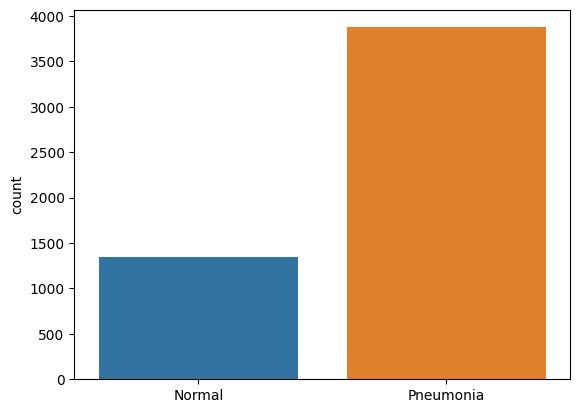

In [11]:
l = []

for i in train:
    if(i[1] == 0):
        l.append("Normal")
    else:
        l.append("Pneumonia")

sns.countplot(x=l)

In [12]:
X_train = []
y_train = []

X_val = []
y_val = []

X_test = []
y_test = []

for feature, label in train:
    X_train.append(feature)
    y_train.append(label)

for feature, label in test:
    X_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    X_val.append(feature)
    y_val.append(label)

In [13]:
X_train = np.array(X_train) / 255.0
X_val = np.array(X_val) / 255.0
X_test = np.array(X_test) / 255.0

In [14]:
X_test.shape

(624, 299, 299)

In [15]:
X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = np.array(y_train)

X_val = X_val.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_val = np.array(y_val)

X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_test = np.array(y_test)

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Conv2D, Activation, Dense, Dropout, MaxPooling2D
from tensorflow.keras.models import Sequential

In [17]:
X_train.shape

(5216, 299, 299, 1)

In [18]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding="same", input_shape=X_train.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation="relu"))

model.add(Dense(1))
model.add(Activation("sigmoid"))

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), shuffle=True, callbacks=[callback])
scores = model.evaluate(X_test, y_test)

model.save("cnn_model.bin")

Epoch 1/50
163/163 [==============================] - 22s 57ms/step - loss: 0.4522 - accuracy: 0.7874 - val_loss: 0.6502 - val_accuracy: 0.5625
Epoch 2/50
163/163 [==============================] - 9s 54ms/step - loss: 0.2307 - accuracy: 0.9110 - val_loss: 0.5765 - val_accuracy: 0.6250
Epoch 3/50
163/163 [==============================] - 9s 54ms/step - loss: 0.1691 - accuracy: 0.9356 - val_loss: 0.4972 - val_accuracy: 0.7500
Epoch 4/50
163/163 [==============================] - 9s 54ms/step - loss: 0.1580 - accuracy: 0.9362 - val_loss: 0.5419 - val_accuracy: 0.6250
Epoch 5/50
163/163 [==============================] - 9s 54ms/step - loss: 0.1485 - accuracy: 0.9433 - val_loss: 0.5004 - val_accuracy: 0.7500
Epoch 6/50
163/163 [==============================] - 9s 54ms/step - loss: 0.1387 - accuracy: 0.9452 - val_loss: 0.4524 - val_accuracy: 0.8125
Epoch 7/50
163/163 [==============================] - 9s 54ms/step - loss: 0.1329 - accuracy: 0.9471 - val_loss: 0.4893 - val_accuracy: 0.750

In [19]:
print("Test loss {}".format(scores[0]))
print("Test accuracy {}".format(scores[1]))

Test loss 0.4352756440639496
Test accuracy 0.8157051205635071


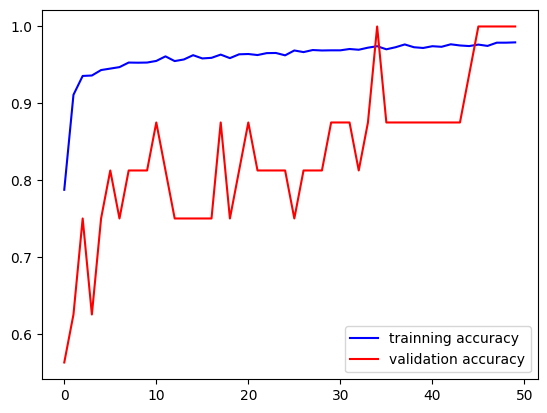

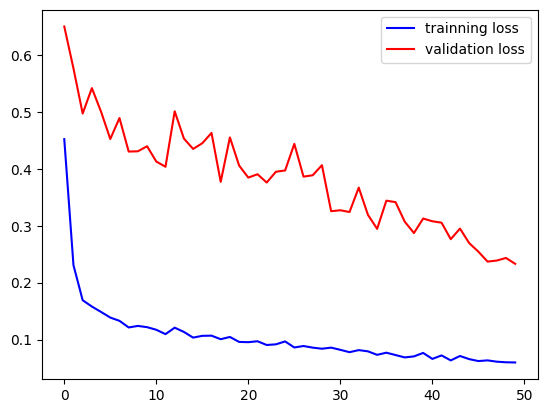

In [20]:
import matplotlib.pyplot as plt
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [21]:
prediction = (model.predict(X_test) > 0.5).astype("int32")
prediction = prediction.reshape(1, -1)[0]
prediction[:15]

20/20 [==============================] - 0s 11ms/step


array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1], dtype=int32)

In [22]:
# correct and incorrect
# you can check tensorflow website

correct = np.nonzero(prediction == y_test)[0]
incorrect = np.nonzero(prediction != y_test)[0]

<ipython-input-23-9b8ada9c79c4>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,j+1)


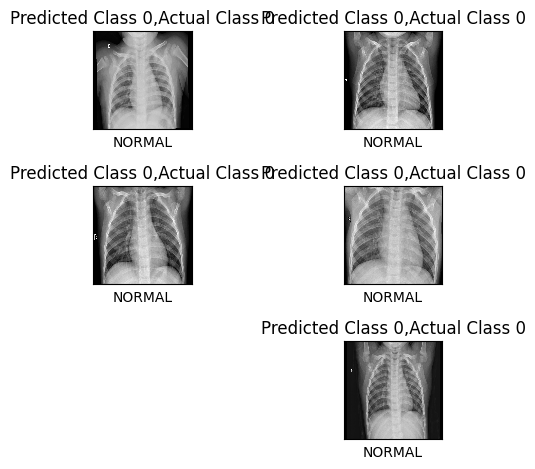

In [23]:
j = 0
for i in correct[:6]:
    plt.subplot(3,2,j+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i].reshape(299,299), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(prediction[i], y_test[i]))
    plt.xlabel(labels[prediction[i]])
    plt.tight_layout()
    j += 1

<ipython-input-24-c7d108cfea78>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,j+1)


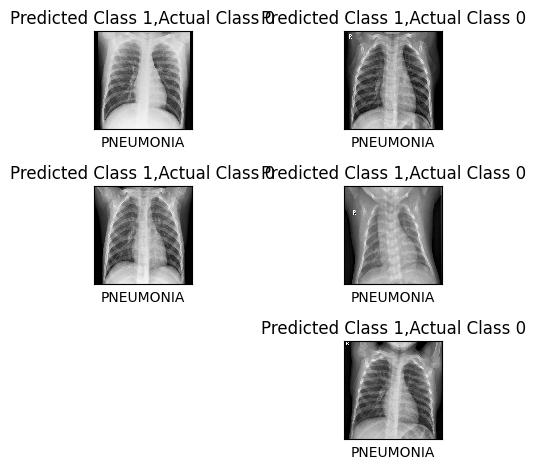

In [24]:
j = 0
for i in incorrect[:6]:
    plt.subplot(3,2,j+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i].reshape(299,299), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(prediction[i], y_test[i]))
    plt.xlabel(labels[prediction[i]])
    plt.tight_layout()
    j += 1

In [25]:
# load model and predict some some external photo

labels = ["NORMAL", "PNEUMONIA"]
def prepare(filepath):
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return new_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)

model = tf.keras.models.load_model("cnn_model.bin") # load model

In [26]:
# extra pneumonia photo from google
prediction = model.predict([prepare("/content/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1430-0001.jpeg")])
print(labels[int(prediction[0])])

1/1 [==============================] - 0s 182ms/step
NORMAL


In [27]:
predictions = model.predict(X_test)
for i in range(len(predictions)):
    predictions[i] = 1 if predictions[i]>0.5 else 0

20/20 [==============================] - 0s 11ms/step


In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [29]:
print(classification_report(y_test,predictions, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.86      0.61      0.71       234
   Normal (Class 1)       0.80      0.94      0.86       390

           accuracy                           0.82       624
          macro avg       0.83      0.77      0.79       624
       weighted avg       0.82      0.82      0.81       624



In [30]:
cm = confusion_matrix(y_test,predictions)
cm = pd.DataFrame(cm,index = ['0','1'], columns = ['0','1'])
cm

,0,1
0,143,91
1,24,366


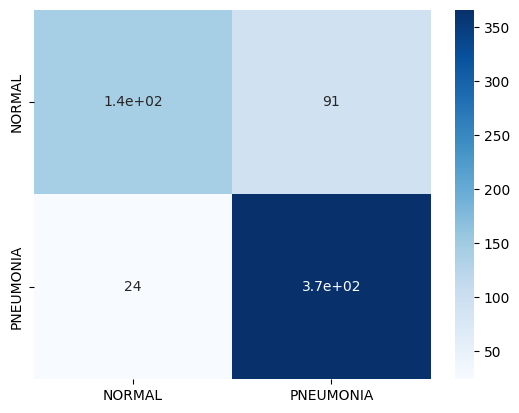

In [31]:
sns.heatmap(cm,cmap="Blues",annot=True, xticklabels = labels,yticklabels=labels)
plt.show()

In [32]:
pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 77.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.9/287.9 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.2/137.2 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 k

In [33]:
import gradio

In [34]:
def pneumoniaPrediction(img):
    img= np.array(img)/255
    img =img.reshape(-1, 299, 299, 1)
    isPneumonic = model.predict(img)[0]
    imgClass="Normal" if isPneumonic<0.5 else "Pneumonia"
    return imgClass

In [35]:
pr = model.predict(X_test)
for i in range(len(pr)): 
  if pr[i]>0.5:
      pr[i]=1
  else:
      pr[i]=0

20/20 [==============================] - 0s 11ms/step


In [68]:
img=gradio.inputs.Image (shape=(299, 299))
label = gradio.outputs.Label (num_top_classes=1)

/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:259: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.10/dist-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


In [37]:
model.save('my_model')

In [38]:
model.save('my_model.h5')

In [69]:
interface = gradio.Interface(fn = pneumoniaPrediction,
                              title = "Pneumonia Detection using Chest X-Ray",
                              inputs=img,
                              outputs = label,
                              interpretation = "default",
                              allow_flagging = "never")
interface.launch(debug=True, share=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().


KeyboardInterrupt: ignored

In [40]:
# extra pneumonia photo from google
prediction = model.predict([prepare("/content/chest_xray/chest_xray/val/NORMAL/NORMAL2-IM-1430-0001.jpeg")])
print(labels[int(prediction[0])])

1/1 [==============================] - 0s 21ms/step
NORMAL


In [41]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [43]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the saved model
model = load_model("/content/my_model.h5")

# Load and preprocess the input image
img_path = "/content/chest_xray/test/PNEUMONIA/person100_bacteria_477.jpeg"
img = image.load_img(img_path, target_size=(299,299), color_mode='grayscale')
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x.astype('float32') / 255

# Select the final convolutional layer
final_conv_layer = model.get_layer("conv2d_3")

# Create a model with the original model's input and the final_conv_layer's output
grad_model = tf.keras.Model([model.inputs], [final_conv_layer.output, model.output])

# Compute the gradients
with tf.GradientTape() as tape:
    inputs = tf.cast(x, tf.float32)
    (conv_outputs, predictions) = grad_model(inputs)
    loss = predictions

grads = tape.gradient(loss, conv_outputs)

pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

# Create the Grad-CAM heatmap
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
heatmap = np.maximum(heatmap, 0)
max_value = np.max(heatmap)
if max_value > 0:
    heatmap /= max_value

heatmap = np.squeeze(heatmap)  # Squeeze any unnecessary dimensions

# Overlay the heatmap on the original image
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

# Save the Grad-CAM image
cv2.imwrite("gradcam3.jpg", superimposed_img)


True

In [48]:
model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [44]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm


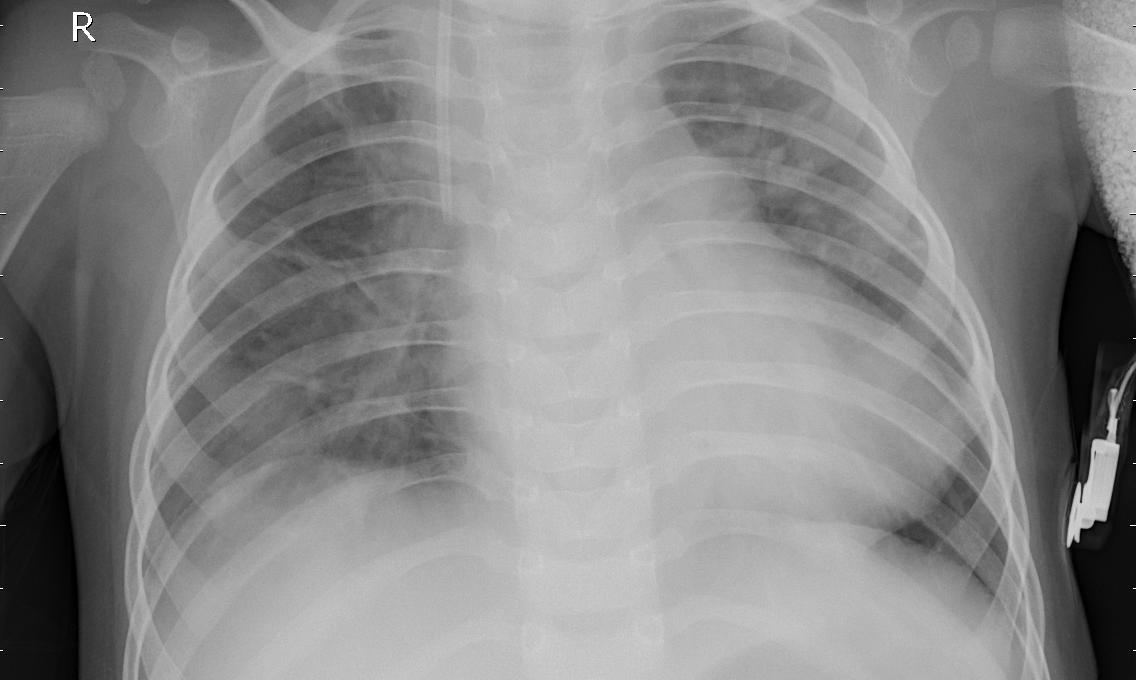

In [52]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block14_sepconv2"

# The local path to our target image
img_path ="/content/chest_xray/chest_xray/test/PNEUMONIA/person101_bacteria_486.jpeg"
display(Image(img_path))

In [53]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

1/1 [==============================] - 1s 703ms/step
Predicted: [('n04040759', 'radiator', 9.181232)]


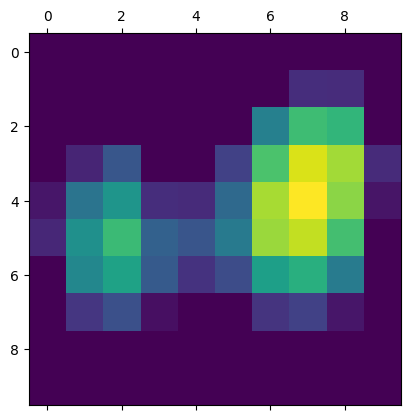

In [54]:
# Prepare image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

<ipython-input-55-34e0b9574523>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


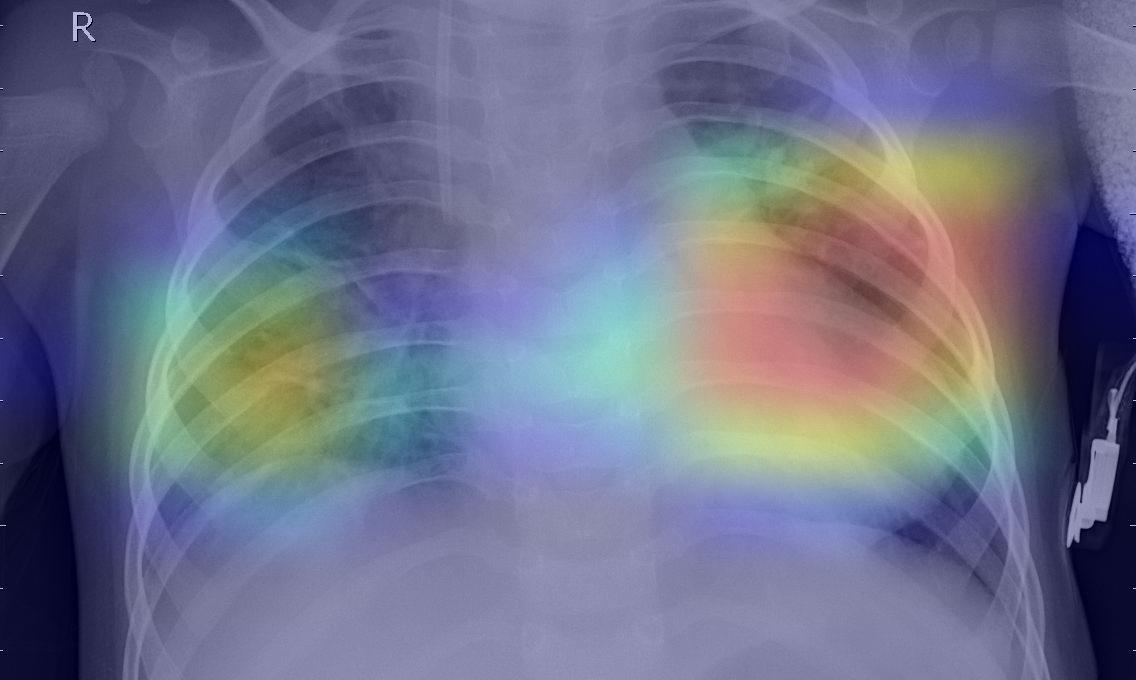

In [55]:
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)